In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


In [12]:
#Set parameters
# Constants
N = 2  # Number of states
M = 3  # Number of actions
Lam_array = [10]  # Setting lambda to a large number is used as an approximation of infinite informational cost
alpha_array = [0.0]  # Set of alpha values. Higher alpha implies higher risk aversion. This should be between 0 and 1.
r_array = [7.5] # Set of payoff values for x = 1, a = 2. This parameterizes the payoff matrix.
eps = 1e-6  # Error tolerance. Higher tolerance means slower computation but more accurate results.

# Time-step increments. Smaller increments will increase the accuracy of the results, but will also increase the computation time
q_step = 0.1
p_step = 0.1
mu_step = 0.1

# Create xi_array from xi_min to xi_max with num_xi steps
def create_xi_array(xi_min, xi_max, num_xi):
    xi_set = np.linspace(xi_min, xi_max, num_xi)
    return xi_set
xi_set = create_xi_array(1, 55, 50)
T = len(xi_set)  # Number of time steps

# Baseline prior
hat_mu = np.ones(N)*(1/N)  

# Initialize results dictionary
results = {}




In [13]:
# Takes in payoff and calculates utility for that payoff.
def utility_function(payoff, alpha):
    if alpha != 1:
        return 1 / (1 - alpha) * (payoff**(1 - alpha) - 1) + 1
    else:
        return np.log(payoff + 1e-7) if payoff > 0 else np.log(payoff + 1e-7)

# Calculates utility for a given state, action, alpha and r value.
# You can change the payoff set here.
def utility(x, a, alpha, r):
    payoff_set = np.array([[0.0, r * 2], [r, 0.0], [5.0, 5.0]])
    return utility_function(payoff_set[a, x], alpha)


In [14]:
#Main Loop. Implements numerical algorithm from Section 3 for each combination of r, alpha, and lambda.
#This does not need to be altered.
for r in r_array:
    utility_r = r
    for Lam in Lam_array:
        for alpha in alpha_array:
            p = np.ones((T, M, N)) / M  # Initial probability p(a|x)
            q = np.zeros((T, M))  # Initial probability q(a)
            v = np.zeros((T, N))  # Value function
            mu = np.zeros((T, N))  # Worst-case prior
            post = np.zeros((T, N, M))  # Posterior distribution

            for t in range(T):
                xi = xi_set[t]
                mu[t, :] = hat_mu
                p_old, q_old, mu_old = p.copy(), q.copy(), mu.copy()

                Iter_err = float('inf')
                while Iter_err > eps:
                    # Update q
                    for a in range(M):
                        q[t, a] = (1 - q_step) * q_old[t, a] + q_step * sum(mu[t, x] * p[t, a, x] for x in range(N))

                    # Update p
                    for x in range(N):
                        den = sum(q[t, a] * np.exp(utility(x, a, alpha, utility_r) / Lam) for a in range(M))
                        for a in range(M):
                            p[t, a, x] = (1 - p_step) * p_old[t, a, x] + p_step * q[t, a] * np.exp(utility(x, a, alpha, utility_r) / Lam) / den

                    # Update v
                    for x in range(N):
                        v[t, x] = Lam * np.log(sum(q[t, a] * np.exp(utility(x, a, alpha, utility_r) / Lam) for a in range(M)))

                    # Update mu
                    den = sum(np.exp(-v[t, x] / xi) * hat_mu[x] for x in range(N))
                    for x in range(N):
                        mu[t, x] = (1 - mu_step) * mu_old[t, x] + mu_step * np.exp(-v[t, x] / xi) * hat_mu[x] / den

                    # Compute iteration error
                    Iter_err = (np.linalg.norm(p[t, :, :] - p_old[t, :, :], 'fro') +
                                np.linalg.norm(q[t, :] - q_old[t, :]) +
                                np.linalg.norm(mu[t, :] - mu_old[t, :]))

                    p_old, q_old, mu_old = p.copy(), q.copy(), mu.copy()

                # Update posterior distribution
                for a in range(M):
                    for x in range(N):
                        if q[t, a] > 1e-4:
                            post[t, x, a] = p[t, a, x] * mu[t, x] / q[t, a]

            # Calculate R (relative entropy)
            R = np.sum(np.log(mu / hat_mu) * mu, axis=1)

            # Calculate I (mutual information)
            I = np.zeros(T)
            for i in range(T):
                q_array = q[i].reshape(-1, 1)
                q_array_2 = np.repeat(q_array, N, axis=1)
                I[i] = np.sum(np.sum(np.log(p[i, :, :] / q_array_2) * p[i, :, :], axis=0) * mu[i])

            # Store results for current r
            results[r] = (p, mu, q, R, I)

/home/chh/ipykernel_742396/285830882.py:15: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, results[r][0][:, 1, 1], '-r', linewidth=2, label=r'$p^*(2)$', linestyle='dashed')
/home/chh/ipykernel_742396/285830882.py:16: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-k" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, results[r][0][:, 2, 1], '-k', linewidth=2, label=r'$p^*(3)$', linestyle='dotted')
/home/chh/ipykernel_742396/285830882.py:20: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-r" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(index, results[r][1][:, 1], '-r', linewidth=2, label=r'$\mu^*(x_2)$', linestyle='dashed')


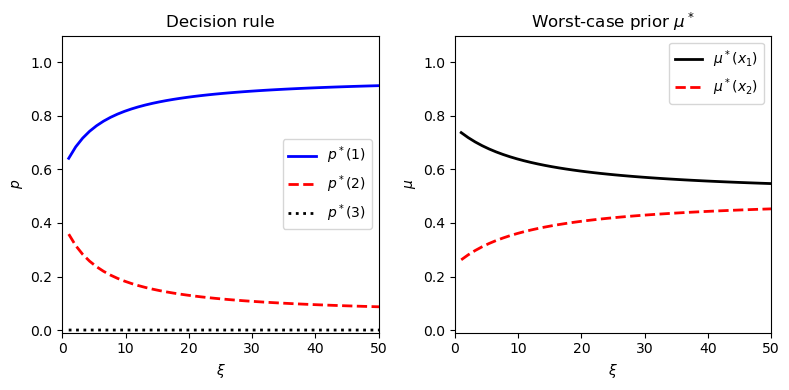

In [20]:
# Plot results
index = xi_set
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

# Subplot configurations
configurations = [
    (axs[0], r_array[0], 1, "Decision rule", 'right'),
    (axs[1], r_array[0], 0, "Worst-case prior $\mu^*$", 'best'),
]

# Plot each subplot
for ax, r, plot_type, title, legend_loc in configurations:
    if plot_type == 1:
        ax.plot(index, results[r][0][:, 0, 1], '-b', linewidth=2, label=r'$p^*(1)$')
        ax.plot(index, results[r][0][:, 1, 1], '-r', linewidth=2, label=r'$p^*(2)$', linestyle='dashed')
        ax.plot(index, results[r][0][:, 2, 1], '-k', linewidth=2, label=r'$p^*(3)$', linestyle='dotted')
        ax.set_ylabel(r'$p$')
    else:
        ax.plot(index, results[r][1][:, 0], '-k', linewidth=2, label=r'$\mu^*(x_1)$')
        ax.plot(index, results[r][1][:, 1], '-r', linewidth=2, label=r'$\mu^*(x_2)$', linestyle='dashed')
        ax.set_ylabel(r'$\mu$')
        
    ax.set_xlabel(r'$\xi$')
    ax.set_title(title)
    ax.legend(loc=legend_loc)
    ax.set_ylim(-0.01, 1.1)
    ax.set_xlim(0, 50)

# Finalize and save the figure
plt.tight_layout()
plt.savefig("notebook_plots/1.png", dpi=300)
np.savez("notebook_results/1.npz", results)
